# Great Britain Emissions
This example notebook will how to use the OpenClimate pyclient to extract emissions and pledge data and make a simple plot.

In [1]:
from oc_client import Client
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import pandas as pd

## OpenClimate Client object
You first need to instantiate an object to interact with the OpenClimate API

In [2]:
# the dev parameter toggles pulling from the development database or not
# the dev database contains bleeding-edge data ingestions
client = Client(dev=True)

## Pull emissions and target data

In [3]:
actor = 'GB'
df_emissions = client.emissions(actor_id=actor)
df_ndc = client.targets(actor_id=actor)

# convert tonnes to megatonnes
df_emissions['total_emissions'] = df_emissions['total_emissions'] / 10**6

# filter emissions by dataset
filt = df_emissions['dataset'] == 'UNFCCC-annex1-GHG'
df_gb = df_emissions.loc[filt]

# filter ndc by target
filt = df_ndc['target_id']=='IGES_NDC:unconditional:GB'
df_ndc = df_ndc.loc[filt]

## Quick plot of emissions
This looks pretty linear

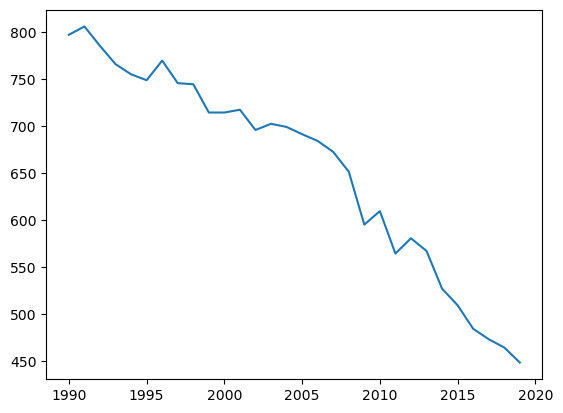

In [4]:
plt.plot(df_gb['year'], df_gb['total_emissions'])

## Question: Is Great Britain on track to meet their emissions target?
The graph looks pretty linear. Let's assume this linear trend continues to estimate when Great Britain will achieve their NDC target. 

In [5]:
def linear_eq(df, start_year=None, year_var='year', emissions_var='total_emissions'):
    '''simple linear regression'''
    filt = df[year_var]>=start_year
    x = df.loc[filt, year_var].values
    y = df.loc[filt, emissions_var].values

    # least-squares linear regression
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x * y)
    sum_xx = np.sum(x * x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # calculate coefficients
    b = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    a = mean_y - b * mean_x

    # Make predictions using the regression line
    pred = lambda x: a + b * x
    return {'equation':pred, 'slope':b, 'intercept':a}

In [6]:
start_year = 1990
pred = linear_eq(df_gb, start_year=start_year)
X_pred = np.arange(start_year, 2031)
Y_pred = pred['equation'](X_pred)

# get target emissions 
filt = df_gb['year']==int(df_ndc['baseline_year'])
target_emissions = df_gb.loc[filt,'total_emissions'] * (100 - int(df_ndc['target_value']))/100

year_target_achieved = round((target_emissions - pred['intercept']) / pred['slope'])
print(f"GB reducing emissions by about {abs(pred['slope']):.0f} MT/yr")
print(f'Target emissions of {int(target_emissions.values)} MT/yr will be acheived around {int(year_target_achieved.values)}')

GB reducing emissions by about 12 MT/yr
Target emissions of 255 MT/yr will be acheived around 2038


#### Note: this depends on the `start_year`, play around with start years to see how this changes the answer

## Plot of emissions with percent completed of target emissions goal

In [7]:
baseline_year = df_ndc['baseline_year'].squeeze()
baseline_emissions = df_gb.loc[df_gb['year']==baseline_year, 'total_emissions'].squeeze()
current_year = df_gb['year'].max()
current_emissions = df_gb.loc[(df_gb['year'] == current_year), 'total_emissions'].squeeze()
target_year = df_ndc['target_year'].squeeze()
target_emissions = target_emissions.squeeze()
target_percent = float(df_ndc['target_value'].squeeze())/100

/var/folders/g0/rt7kg75d1bq_ptpk0lzn3m5h0000gn/T/ipykernel_49342/709186654.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f"{int(x)}%" for x in vals])


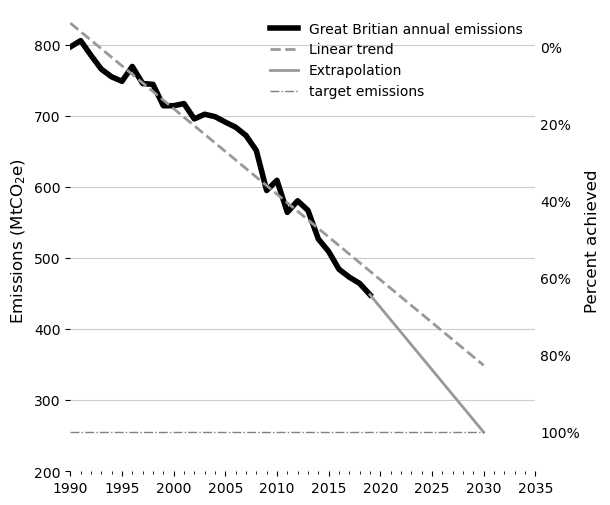

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(df_gb['year'], df_gb['total_emissions'], 
        linewidth=4, 
        label='Great Britian annual emissions',
       color=[0.0,0.0,0.0])

ax.plot(X_pred, Y_pred, '--', 
        linewidth=2, 
        color=[0.6,0.6,0.6],
       label='Linear trend')

ax.plot([current_year, target_year], [current_emissions, target_emissions], 
        '-', 
        linewidth=2, 
        color=[0.6,0.6,0.6],
       label='Extrapolation')


ax.plot([df_ndc['baseline_year'], df_ndc['target_year']],
        [target_emissions, target_emissions], 
        '-.', 
        linewidth=1, 
        color=[0.5,0.5,0.5],
       label='target emissions')

ylim = [200, 850]
ax.set_ylim(ylim)
ax.set_xlim([1990, 2035])

# Turn off the display of all ticks.
ax.tick_params(which='both',     # Options for both major and minor ticks
               top='off',        # turn off top ticks
               left='off',       # turn off left ticks
               right='off',      # turn off right ticks
               bottom='off')     # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# major/minor tick lines
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', 
        which='major', 
        color=[0.8, 0.8, 0.8], linestyle='-')

ylim_achieved = [(baseline_emissions - ylim[0])/ (baseline_emissions*target_percent)*100,
                 (baseline_emissions - ylim[1])/ (baseline_emissions*target_percent)*100]
ax2 = ax.twinx()
ax2.set_ylim(ylim_achieved)

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('right')
ax2.xaxis.set_ticks_position('bottom')

ax2.yaxis.set_tick_params(size=0)

# manipulate y labels
vals = ax2.get_yticks()
ax2.set_yticklabels([f"{int(x)}%" for x in vals])
ax2.set_ylabel("Percent achieved", fontsize=12)

ax.set_ylabel("Emissions (MtCO$_2$e)", fontsize=12)
ax.legend(loc='upper right', frameon=False)